# LRP Analysis
---
Now that the RNN is trained and providing accurate results, we would like to apply Layer-Wise Relevance Propagation (LRP) on the network to better understand its predictions

In [1]:
# TensorFlow and tf.keras

# import tensorflow as tf

# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras import models
# import tensorflow.keras.utils
import pandas as pd

import keras
import keras.backend
from keras import layers
from keras import models
import keras.utils



# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle
from scipy import stats,special

import os

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

## Data

Import the data again to work with in analysis.

In [2]:
data = np.load('/mnt/data/ml/Constituent4vec_addgroomedtau.npz')

pt = data['jetconstPt_log']
eta = data['delta_eta']
phi = data['delta_phi']
labels = data['labels']
tau21 = data['tau21']
chMult = data['isCh']

#fix values outside jet
#eta[eta < -0.8] = 0
#eta[eta > 0.8] = 0
#phi[phi < -0.8] = 0
#phi[phi > 0.8] = 0

labels = labels[::20]
tau21 = tau21[::20]
chMult = np.sum(chMult, axis = 1)

fourvec = np.stack((pt,eta,phi), axis = -1)

qcd_vec = fourvec[np.where(labels[:,0] == 1)]
qcd_tau = tau21[np.where(labels[:,0] == 1)]
qcd_mult = chMult[np.where(labels[:,0] == 1)]

z_vec = fourvec[np.where(labels[:,1] == 1)]
z_tau = tau21[np.where(labels[:,1] == 1)]
z_mult = chMult[np.where(labels[:,1] == 1)]

#ensure same number of signal vs. background
qcd_vec = qcd_vec[:len(z_vec)]
qcd_tau = qcd_tau[:len(z_tau)]
qcd_mult = qcd_mult[:len(z_mult)]

qcd_vec = qcd_vec[::10]
qcd_tau = qcd_tau[::10]
qcd_mult = qcd_mult[::10]

z_vec = z_vec[::10]
z_tau = z_tau[::10]
z_mult = z_mult[::10]


qcd_lab = np.zeros([len(qcd_vec), 2])
qcd_lab[:,0] = 1
z_lab = np.zeros([len(qcd_vec), 2])
z_lab[:,1] = 1


fourvec = np.vstack((qcd_vec, z_vec))
taus = np.hstack((qcd_tau, z_tau))
mults = np.hstack((qcd_mult, z_mult))
labels = np.vstack((qcd_lab, z_lab))
print(len(labels), len(fourvec))

n_data = len(fourvec)
testvec = fourvec[::4]
testlabels = labels[::4]
testtaus = taus[::4]
testmults = mults[::4]

mask_vec = np.ones(fourvec.shape,dtype=bool)
mask_vec[::4] = 0
mask_vec[1::8] = 0
mask_lab = np.ones(labels.shape,dtype=bool)
mask_lab[::4] = 0
mask_lab[1::8] = 0
mask_tau = np.ones(taus.shape,dtype=bool)
mask_tau[::4] = 0
mask_tau[1::8] = 0
mask_mult = np.ones(mults.shape,dtype=bool)
mask_mult[::4] = 0
mask_mult[1::8] = 0

valvec = fourvec[1::8]
vallabels = labels[1::8]
valtaus = taus[1::8]
valmults = mults[1::8]

train_len = (n_data-len(testvec)-len(valvec))

trainvec = fourvec[mask_vec].reshape(train_len,20,3)
trainlabels = labels[mask_lab].reshape(train_len, 2)
traintaus = taus[mask_tau].reshape(train_len, 1)
trainmults = mults[mask_mult].reshape(train_len, 1)



176556 176556


In [3]:
best_model = keras.models.load_model('model/RNN.h5') #loading the model in

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [4]:
import innvestigate
import innvestigate.utils as iutils

## General Analysis

Now we create our LRP anaylzer and feed the network and data to it.

In [5]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(best_model)
# Creating an analyzer
lrp_analyzer = innvestigate.create_analyzer("lrp.z", model_wo_softmax)

/opt/conda/lib/python3.7/site-packages/innvestigate/analyzer/base.py:110: UserWarning: LRP is only tested for convolutional neural networks.
Check triggerd by layers: [<keras.layers.recurrent.GRU object at 0x7fa00847a588>, <keras.layers.recurrent.GRU object at 0x7fa0084854a8>, <keras.layers.recurrent.GRU object at 0x7fa0084856a0>]
  warnings.warn(tmp_message)


In [6]:
bin_num = 32
mult_bins = np.arange(0,20,1) #needs custom binning to get a smooth distribution
angle_bins = np.linspace(-0.8,0.8, bin_num+1) #exclude areas outside jet

In [7]:
#to stop kernel from dying
qcd_vec = qcd_vec[::2]
qcd_tau = qcd_tau[::2]
qcd_mult = qcd_mult[::2]

z_vec = z_vec[::2]
z_tau = z_tau[::2]
z_mult = z_mult[::2]

### QCD

In [8]:
analysis_qcd = lrp_analyzer.analyze([qcd_vec,qcd_tau,qcd_mult])

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [9]:
pt_analysis_qcd = analysis_qcd[0][:,:,0].flatten()
eta_analysis_qcd = analysis_qcd[0][:,:,1].flatten()
phi_analysis_qcd = analysis_qcd[0][:,:,2].flatten()
tau_analysis_qcd = analysis_qcd[1].flatten()
mult_analysis_qcd = analysis_qcd[2].flatten()

w_pt_qcd,  edges_pt_qcd = np.histogram(qcd_vec[:,:,0].flatten(), weights = pt_analysis_qcd, bins = bin_num)
w_eta_qcd,  edges_eta_qcd = np.histogram(qcd_vec[:,:,1].flatten(), weights = eta_analysis_qcd, bins = angle_bins)
w_phi_qcd,   edges_phi_qcd = np.histogram(qcd_vec[:,:,2].flatten(), weights = phi_analysis_qcd, bins = angle_bins)
w_tau_qcd,  edges_tau_qcd = np.histogram(qcd_tau, weights = tau_analysis_qcd, bins = bin_num)
w_mult_qcd,  edges_mult_qcd = np.histogram(qcd_mult, weights = mult_analysis_qcd, bins = mult_bins)

edges_qcd = np.concatenate((edges_pt_qcd, edges_eta_qcd, edges_phi_qcd, edges_tau_qcd), axis=0)
edges_qcd = edges_qcd.reshape(4, bin_num +1)

half_bin_qcd = (edges_qcd[:,1]-edges_qcd[:,0])/2
half_bin_qcd = half_bin_qcd.reshape(4,1)
x_qcd = edges_qcd[:,0:-1]+half_bin_qcd

mult_half_bin_qcd=(edges_mult_qcd[1]-edges_mult_qcd[0])/2
x_mult_qcd = edges_mult_qcd[0:-1]+mult_half_bin_qcd

### Z

In [10]:
analysis_z = lrp_analyzer.analyze([z_vec,z_tau,z_mult])

In [11]:
pt_analysis_z = analysis_z[0][:,:,0].flatten()
eta_analysis_z = analysis_z[0][:,:,1].flatten()
phi_analysis_z = analysis_z[0][:,:,2].flatten()
tau_analysis_z = analysis_z[1].flatten()
mult_analysis_z = analysis_z[2].flatten()

w_pt_z,  edges_pt_z = np.histogram(z_vec[:,:,0].flatten(), weights = pt_analysis_z, bins = bin_num)
w_eta_z,  edges_eta_z = np.histogram(z_vec[:,:,1].flatten(), weights = eta_analysis_z, bins = angle_bins)
w_phi_z,   edges_phi_z = np.histogram(z_vec[:,:,2].flatten(), weights = phi_analysis_z, bins = angle_bins)
w_tau_z,  edges_tau_z = np.histogram(z_tau, weights = tau_analysis_z, bins = bin_num)
w_mult_z,  edges_mult_z = np.histogram(z_mult, weights = mult_analysis_z, bins = mult_bins)

edges_z = np.concatenate((edges_pt_z, edges_eta_z, edges_phi_z, edges_tau_z), axis=0)
edges_z = edges_z.reshape(4,bin_num+1)

half_bin_z = (edges_z[:,1]-edges_z[:,0])/2
half_bin_z = half_bin_z.reshape(4,1)
x_z = edges_z[:,0:-1]+half_bin_z

mult_half_bin_z=(edges_mult_z[1]-edges_mult_z[0])/2
x_mult_z = edges_mult_z[0:-1]+mult_half_bin_z

### Plots

In [12]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'white'}
plt.rcParams.update(params)
plt.style.context('default')

In [13]:
# Some of the data has non-physicals zeros in eta and phi we can remove
qcd_vec_fix = np.delete(qcd_vec, np.where(qcd_vec[:,:,2]==0), axis = 0)
zvec_fix = np.delete(z_vec, np.where(z_vec[:,:,2]==0), axis = 0)

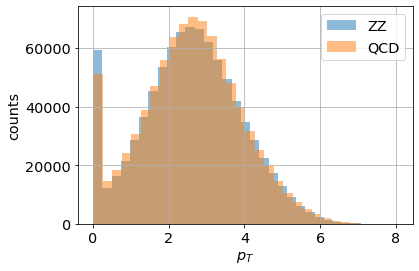

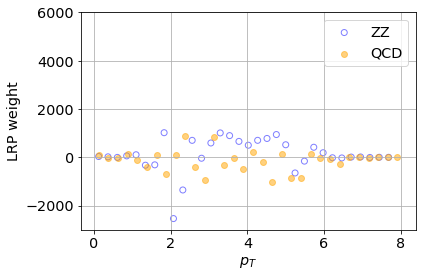

In [14]:
#plt.figure(figsize = (12,4))
#plt.subplot(1,2,1)

plt.figure(facecolor = "white")
plt.hist(zvec_fix[:,:,0].flatten(), bins = bin_num, alpha = 0.5, label ="ZZ")
plt.hist(qcd_vec_fix[:,:,0].flatten(), bins = bin_num, alpha = 0.5, label = "QCD")

plt.legend(fontsize = 'x-large')
#plt.title("unweighted pt values", fontsize = 15)
plt.xlabel("$p_T$", fontsize = 'x-large')
plt.ylabel("counts", fontsize = 'x-large')
plt.grid()
plt.show()
#plt.subplot(1,2,2)

plt.figure(facecolor = "white")
plt.scatter(x_z[0], w_pt_z , alpha = 0.5,label = 'ZZ', facecolors='none', edgecolors='blue')
plt.scatter(x_qcd[0], w_pt_qcd , alpha = 0.5, label = 'QCD', color = 'orange')
plt.ylim(-3000,6000)
plt.legend(fontsize = 'x-large')
#plt.title( "pt weighted by relevance", fontsize = 'x-large')
plt.xlabel("$p_T$", fontsize = 'x-large')
plt.ylabel("LRP weight", fontsize = 'x-large')
plt.grid()
plt.show()

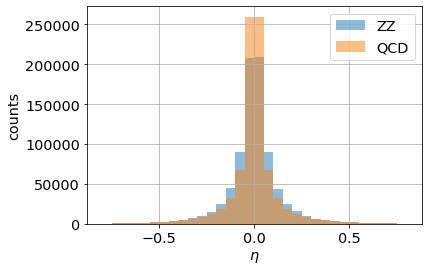

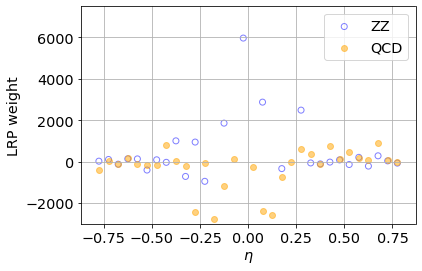

In [15]:
#plt.figure(figsize = (12,4))
#plt.subplot(1,2,1)

plt.figure(facecolor = "white")
plt.hist(zvec_fix[:,:,1].flatten(), bins = angle_bins, alpha = 0.5, label ="ZZ")
plt.hist(qcd_vec_fix[:,:,1].flatten(), bins = angle_bins, alpha = 0.5, label = "QCD")

plt.legend(fontsize = 'x-large')
#plt.title("unweighted pt values", fontsize = 15)
plt.xlabel("$\eta$", fontsize = 'x-large')
plt.ylabel("counts", fontsize = 'x-large')
plt.grid()
plt.show()
#plt.subplot(1,2,2)

plt.figure(facecolor = "white")
plt.scatter(x_z[1], w_eta_z, alpha = 0.5,label = 'ZZ', facecolors='none', edgecolors='blue')
plt.scatter(x_qcd[1], w_eta_qcd, alpha = 0.5, label = 'QCD', color = "orange")
plt.ylim(-3000,7500)
plt.legend(fontsize = 'x-large')
#plt.title( "pt weighted by relevance", fontsize = 'x-large')
plt.xlabel("$\eta$", fontsize = 'x-large')
plt.ylabel("LRP weight", fontsize = 'x-large')
plt.grid()
plt.show()

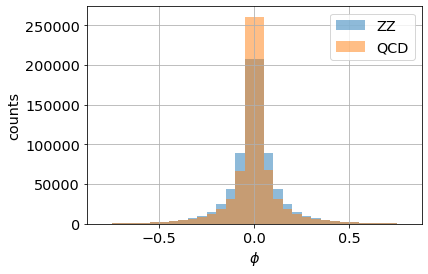

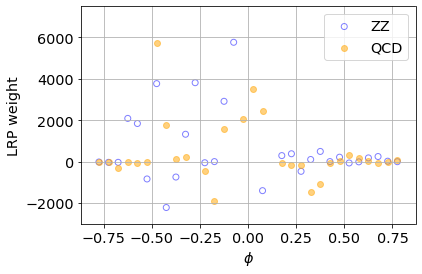

In [16]:
#plt.figure(figsize = (12,4))
#plt.subplot(1,2,1)

plt.figure(facecolor = "white")
plt.hist(zvec_fix[:,:,2].flatten(), bins = angle_bins, alpha = 0.5, label ="ZZ")
plt.hist(qcd_vec_fix[:,:,2].flatten(), bins = angle_bins, alpha = 0.5, label = "QCD")

plt.legend(fontsize = 'x-large')
#plt.title("unweighted pt values", fontsize = 15)
plt.xlabel("$\phi$", fontsize = 'x-large')
plt.ylabel("counts", fontsize = 'x-large')
plt.grid()
plt.show()
#plt.subplot(1,2,2)

plt.figure(facecolor = "white")
plt.scatter(x_z[2], w_phi_z , alpha = 0.5,label = 'ZZ', facecolors='none', edgecolors='blue')
plt.scatter(x_qcd[2], w_phi_qcd  , alpha = 0.5, label = 'QCD', color= "orange")
plt.ylim(-3000,7500)

plt.legend(fontsize = 'x-large')
#plt.title( "pt weighted by relevance", fontsize = 'x-large')
plt.xlabel("$\phi$", fontsize = 'x-large')
plt.ylabel("LRP weight", fontsize = 'x-large')
plt.grid()
plt.show()

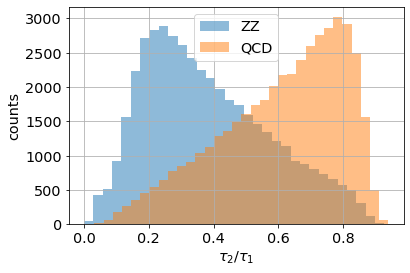

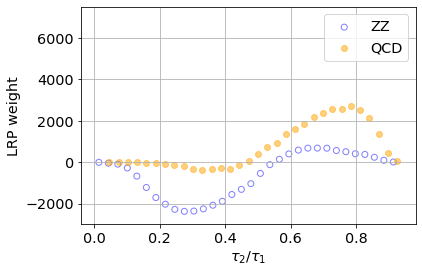

In [17]:
#plt.figure(figsize = (12,4))
#plt.subplot(1,2,1)

plt.figure(facecolor = "white")
plt.hist(z_tau, bins = bin_num, alpha = 0.5, label ="ZZ")
plt.hist(qcd_tau, bins = bin_num, alpha = 0.5, label = "QCD")

plt.legend(fontsize = 'x-large')
#plt.title("unweighted pt values", fontsize = 15)
plt.xlabel('$\\tau_2 / \\tau_1$', fontsize = 'x-large')
plt.ylabel("counts", fontsize = 'x-large')
plt.grid()
plt.show()
#plt.subplot(1,2,2)

plt.figure(facecolor = "white")
plt.scatter(x_z[3], w_tau_z, alpha = 0.5,label = 'ZZ', facecolors='none', edgecolors='blue')
plt.scatter(x_qcd[3], w_tau_qcd, alpha = 0.5, label = 'QCD', color = "orange")
plt.ylim(-3000,7500)

plt.legend(fontsize = 'x-large')
#plt.title( "pt weighted by relevance", fontsize = 'x-large')
plt.xlabel("$\\tau_2 / \\tau_1$", fontsize = 'x-large')
plt.ylabel("LRP weight", fontsize = 'x-large')
plt.grid()
plt.show()

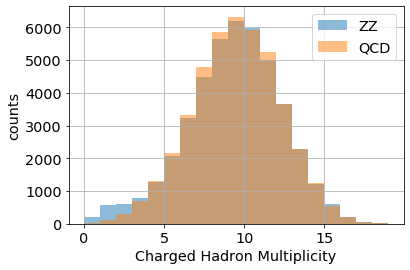

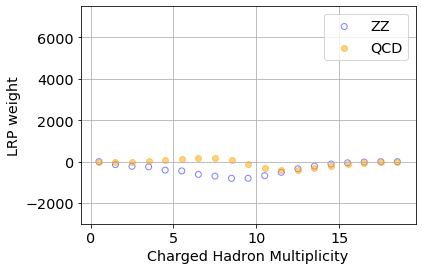

In [18]:
#plt.figure(figsize = (12,4))
#plt.subplot(1,2,1)

plt.figure(facecolor = "white")
plt.hist(z_mult, bins = mult_bins, alpha = 0.5, label ="ZZ")
plt.hist(qcd_mult, bins = mult_bins, alpha = 0.5, label = "QCD")

plt.legend(fontsize = 'x-large')
#plt.title("unweighted pt values", fontsize = 15)
plt.xlabel('Charged Hadron Multiplicity', fontsize = 'x-large')
plt.ylabel("counts", fontsize = 'x-large')
plt.grid()
plt.show()
#plt.subplot(1,2,2)

plt.figure(facecolor = "white")
plt.scatter(x_mult_z, w_mult_z, alpha = 0.5,label = 'ZZ', facecolors='none', edgecolors='blue')
plt.scatter(x_mult_qcd, w_mult_qcd, alpha = 0.5, label = 'QCD', color = "orange")
plt.ylim(-3000,7500)

plt.legend(fontsize = 'x-large')
#plt.title( "pt weighted by relevance", fontsize = 'x-large')
plt.xlabel("Charged Hadron Multiplicity", fontsize = 'x-large')
plt.ylabel("LRP weight", fontsize = 'x-large')
plt.grid()
plt.show()

## Conclusion

As expected, the network is not learning useful information from the four-vector data, as it returns rather random relevance scores. However, it is making a distinction when it to tau21 and charge multiplicity. At lower values of each, the network is more likely to give a Z classification, whereas higher values the network is classyfing as QCD. 

## Functions

In [19]:
def make_profile_data(x,values,bins):
    bin_mean, bin_edges, _ = stats.binned_statistic(x,
                                                    values,
                                                    statistic = 'mean',
                                                    bins = bins)
    bin_std, _, _ = stats.binned_statistic(x,
                                           values,
                                           statistic = 'std',
                                           bins = bins)
    bin_count, _, _ = stats.binned_statistic(x,
                                             x,
                                             statistic = 'count',
                                             bins = bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return bin_mean, bin_std, bin_count, bin_edges, bin_centers, bin_width


## Data 

In [20]:
# Drop all events where the model predicted its result with less confidence then this
confidence_cut = 0.7

In [21]:
predict = best_model.predict([testvec , testtaus,testmults])

In [22]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(best_model)
# Creating an analyzer
lrp_analyzer = innvestigate.create_analyzer("lrp.epsilon", model_wo_softmax)

analysis = lrp_analyzer.analyze([testvec, testtaus, testmults])

In [23]:
ind_true_positive=np.argwhere((predict[:,1]>confidence_cut)&(testlabels[:,1]==1)).flatten()
ind_true_negative=np.argwhere((predict[:,0]>confidence_cut)&(testlabels[:,0]==1)).flatten()
ind_false_positive=np.argwhere((predict[:,1]>confidence_cut)&(testlabels[:,0]==1)).flatten()
ind_false_negative=np.argwhere((predict[:,0]>confidence_cut)&(testlabels[:,1]==1)).flatten()

ind_sig=np.argwhere(testlabels[:,1]==1).flatten()
ind_bkg=np.argwhere(testlabels[:,0]==1).flatten()

In [24]:
X_tp= testvec[:,:,0][ind_true_positive]
X_tn= testvec[:,:,0][ind_true_negative] 
X_fp= testvec[:,:,0][ind_false_positive]
X_fn= testvec[:,:,0][ind_false_negative]

In [25]:
X_sig= testvec[:,:,0][ind_sig] 
X_bkg= testvec[:,:,0][ind_bkg] 

In [26]:
LRP_tp= analysis[0][:,:,0][ind_true_positive]
LRP_tn= analysis[0][:,:,0][ind_true_negative]
LRP_fp= analysis[0][:,:,0][ind_false_positive]
LRP_fn= analysis[0][:,:,0][ind_false_negative]

In [27]:
bins = 50

In [28]:
bin_mean_tp, bin_std_tp, bin_count_tp, bin_edges, bin_centers, bin_width = make_profile_data(X_tp.flatten(), LRP_tp.flatten(), bins)
bin_mean_tn, bin_std_tn, bin_count_tn, _, _, _  = make_profile_data(X_tn.flatten(), LRP_tn.flatten(), bins)
bin_mean_fp, bin_std_fp, bin_count_fp, _, _, _  = make_profile_data(X_fp.flatten(), LRP_fp.flatten(), bins)
bin_mean_fn, bin_std_fn, bin_count_fn, _, _, _  = make_profile_data(X_fn.flatten(), LRP_fn.flatten(), bins)

/opt/conda/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:569: RuntimeWarning: invalid value encountered in sqrt
  (flatsum[a] / flatcount[a]) ** 2)


Text(0, 0.5, 'LRP score')

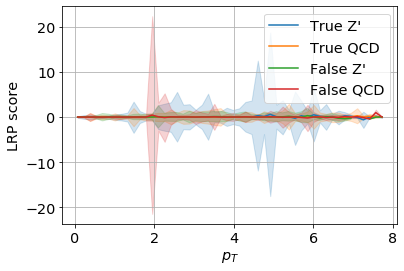

In [29]:
plt.plot(bin_centers, bin_mean_tp, color = 'C0', label = "True Z'")
plt.plot(bin_centers, bin_mean_tn, color = 'C1', label = "True QCD")
plt.plot(bin_centers, bin_mean_fp, color = 'C2', label = "False Z'")
plt.plot(bin_centers, bin_mean_fn, color = 'C3', label = "False QCD")
plt.fill_between(bin_centers, bin_mean_tp - bin_std_tp, bin_mean_tp + bin_std_tp, color = 'C0', alpha = 0.2)
plt.fill_between(bin_centers, bin_mean_tn - bin_std_tn, bin_mean_tn + bin_std_tn, color = 'C1', alpha = 0.2)
plt.fill_between(bin_centers, bin_mean_fp - bin_std_fp, bin_mean_fp + bin_std_fp, color = 'C2', alpha = 0.2)
plt.fill_between(bin_centers, bin_mean_fn - bin_std_fn, bin_mean_fn + bin_std_fn, color = 'C3', alpha = 0.2)
plt.legend()
plt.grid()
#axs[1][1].set_xlim(0,1)
#axs[1][1].xaxis.set_ticks(np.arange(0, 1.2, 0.2))
plt.xlabel('$p_T$')
plt.ylabel('LRP score')
#axs[1][1].set_title('LRP_score over normalized ' + feat);


In [30]:
def make_LRP_plot(data, labels, prediction, LRP, confidence_cut, bins):
    ind_true_positive=np.argwhere((predict[:,1]>confidence_cut)&(labels[:,1]==1)).flatten()
    ind_true_negative=np.argwhere((predict[:,0]>confidence_cut)&(labels[:,0]==1)).flatten()
    ind_false_positive=np.argwhere((predict[:,1]>confidence_cut)&(labels[:,0]==1)).flatten()
    ind_false_negative=np.argwhere((predict[:,0]>confidence_cut)&(labels[:,1]==1)).flatten()

    ind_sig=np.argwhere(labels[:,1]==1).flatten()
    ind_bkg=np.argwhere(labels[:,0]==1).flatten()
    
    X_tp= data[ind_true_positive]
    X_tn= data[ind_true_negative] 
    X_fp= data[ind_false_positive]
    X_fn= data[ind_false_negative]
    
    X_sig= data[ind_sig] 
    X_bkg= data[ind_bkg] 
    
    LRP_tp= LRP[ind_true_positive]
    LRP_tn= LRP[ind_true_negative]
    LRP_fp= LRP[ind_false_positive]
    LRP_fn= LRP[ind_false_negative]
    
    bin_mean_tp, bin_std_tp, bin_count_tp, bin_edges, bin_centers, bin_width = make_profile_data(X_tp.flatten(), LRP_tp.flatten(), bins)
    bin_mean_tn, bin_std_tn, bin_count_tn, _, _, _  = make_profile_data(X_tn.flatten(), LRP_tn.flatten(), bins)
    bin_mean_fp, bin_std_fp, bin_count_fp, _, _, _  = make_profile_data(X_fp.flatten(), LRP_fp.flatten(), bins)
    bin_mean_fn, bin_std_fn, bin_count_fn, _, _, _  = make_profile_data(X_fn.flatten(), LRP_fn.flatten(), bins)
    
    plt.plot(bin_centers, bin_mean_tp, color = 'C0', label = "True ZZ")
    plt.plot(bin_centers, bin_mean_tn, color = 'C1', label = "True QCD")
    #plt.plot(bin_centers, bin_mean_fp, color = 'C2', label = "False Z'")
    #plt.plot(bin_centers, bin_mean_fn, color = 'C3', label = "False QCD")
    plt.fill_between(bin_centers, bin_mean_tp - bin_std_tp, bin_mean_tp + bin_std_tp, color = 'C0', alpha = 0.2)
    plt.fill_between(bin_centers, bin_mean_tn - bin_std_tn, bin_mean_tn + bin_std_tn, color = 'C1', alpha = 0.2)
    #plt.fill_between(bin_centers, bin_mean_fp - bin_std_fp, bin_mean_fp + bin_std_fp, color = 'C2', alpha = 0.2)
    #plt.fill_between(bin_centers, bin_mean_fn - bin_std_fn, bin_mean_fn + bin_std_fn, color = 'C3', alpha = 0.2)
    plt.legend()
    plt.grid()

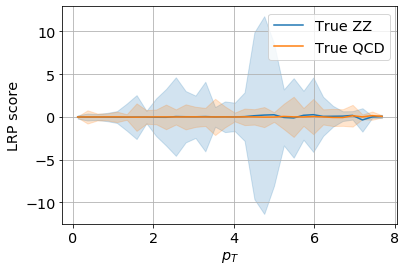

In [31]:
make_LRP_plot(testvec[:,:,0], testlabels, predict, analysis[0][:,:,0], confidence_cut, 32)
plt.xlabel('$p_T$')
plt.ylabel('LRP score')
plt.show()

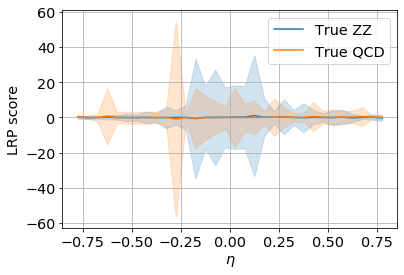

In [32]:
make_LRP_plot(testvec[:,:,1], testlabels, predict, analysis[0][:,:,1], confidence_cut, angle_bins)
plt.xlabel('$\eta$')
plt.ylabel('LRP score')
plt.show()

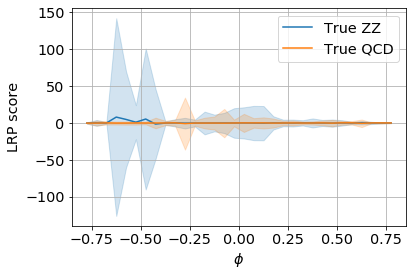

In [33]:
make_LRP_plot(testvec[:,:,2], testlabels, predict, analysis[0][:,:,2], confidence_cut, angle_bins)
plt.xlabel('$\phi$')
plt.ylabel('LRP score')
plt.show()

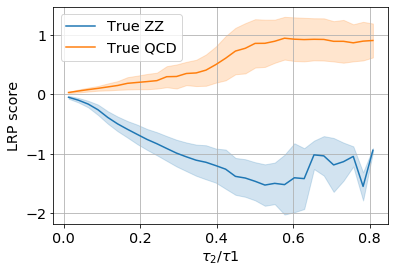

In [34]:
make_LRP_plot(testtaus, testlabels, predict, analysis[1], confidence_cut, 32)
plt.xlabel('$\\tau_2 / \\tau1$')
plt.ylabel('LRP score')
plt.show()

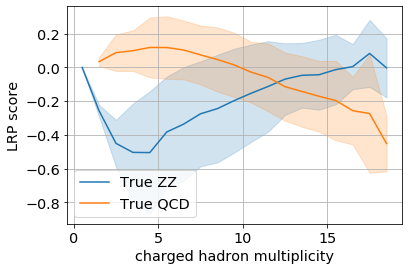

In [35]:
make_LRP_plot(testmults, testlabels, predict, analysis[2], confidence_cut, mult_bins)
plt.xlabel('charged hadron multiplicity')
plt.ylabel('LRP score')
plt.show()